Epoch 1/5
Processing file: C:\Users\Mohammadreza\Desktop\My Class\Proj-DC\My Works\My Papers\intrusion\data generator\pure_data\pure_iq_samples_1.csv
Step 1/1000, Loss: 1.2768678665161133
1/1 [==============================] - 2s 2s/step
Step 101/1000, Loss: 1.0226545333862305
1/1 [==============================] - 0s 46ms/step
Step 201/1000, Loss: 1.015163779258728
1/1 [==============================] - 0s 18ms/step
Step 301/1000, Loss: 1.012669563293457
1/1 [==============================] - 0s 25ms/step
Step 401/1000, Loss: 1.0099035501480103
1/1 [==============================] - 0s 25ms/step
Step 501/1000, Loss: 1.007642149925232
1/1 [==============================] - 0s 24ms/step
Step 601/1000, Loss: 1.0071672201156616
1/1 [==============================] - 0s 27ms/step
Step 701/1000, Loss: 1.0048350095748901
1/1 [==============================] - 0s 52ms/step
Step 801/1000, Loss: 0.9982606172561646
1/1 [==============================] - 0s 32ms/step
Step 901/1000, Loss: 1.003267

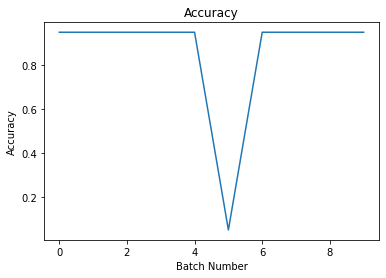

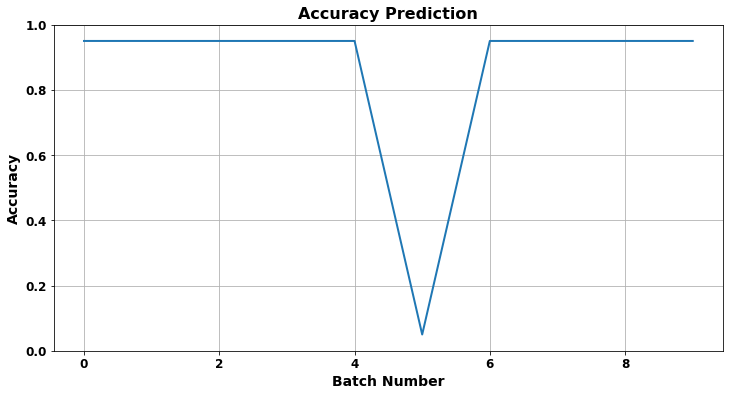

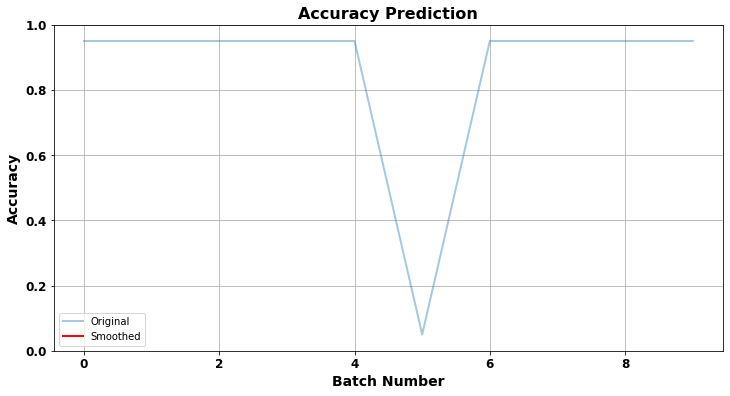

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

# Custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    y_pred_clipped = tf.clip_by_value(y_pred, 1e-9, 1.0)  # Clip values to avoid log(0)
    entropy_reg = -tf.reduce_mean(y_pred_clipped * tf.math.log(y_pred_clipped))
    lambda_entropy = 0.01
    return mse + lambda_entropy * entropy_reg

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class CSVDataGenerator:
    def __init__(self, file_pattern, batch_size, sequence_length, max_samples=None, for_training=True):     
        self.file_pattern = file_pattern
        self.file_list = sorted(glob.glob(self.file_pattern))
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0

    def _load_next_file(self):
        if self.current_file_idx >= len(self.file_list):
            print("No more files to process.")
            raise StopIteration

        current_file = self.file_list[self.current_file_idx]
        df = pd.read_csv(current_file)

        # Filter out rows where 'IQ Data' is '0j'
        df['IQ Data'] = df['IQ Data'].apply(lambda x: complex(x.replace('i', 'j')))
        df = df[df['IQ Data'] != 0j]

        # Check if DataFrame is empty or 'IQ Data' column is missing
        if df.empty or 'IQ Data' not in df.columns:
            raise ValueError(f"File {current_file} is empty or missing 'IQ Data' column after filtering 0j.")

        # If not for training, extract the labels
        if not self.for_training and 'label' in df.columns:
            self.labels_iterator = iter(df['label'].map(lambda x: 1 if x == 'jammer' else 0).values)
        else:
            self.labels_iterator = None

        print(f"Processing file: {current_file}")
        self.dataframe_iterator = iter(df['IQ Data'].values)
        self.current_file_idx += 1

    # Reset function to be used when switching from training to prediction
    def reset_for_prediction(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.dataframe_iterator = None
        self._load_next_file()  # Start from the first file again

    def __iter__(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self._load_next_file()
        return self

    def process_data(self, samples):
        real_parts = np.real(samples)
        imag_parts = np.imag(samples)

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = np.array(list(zip(real_parts, imag_parts))).reshape(-1, self.sequence_length, 2)
        return X
    def __next__(self):
        if self.max_samples and self.total_samples_processed >= self.max_samples:
            raise StopIteration("Reached max_samples limit.")

        while len(self.samples_buffer) < self.batch_size * self.sequence_length:
            try:
                chunk = next(self.dataframe_iterator)
                self.samples_buffer.append(chunk)
                if not self.for_training and self.labels_iterator is not None:
                    label_chunk = next(self.labels_iterator)
                    self.labels_buffer.append(label_chunk)
            except StopIteration:
                if self.current_file_idx >= len(self.file_list):
                    raise StopIteration("No more data to process.")
                self._load_next_file()

        samples = self.samples_buffer[:self.batch_size * self.sequence_length]
        self.samples_buffer = self.samples_buffer[self.batch_size * self.sequence_length:]

        X_chunk = self.process_data(np.array(samples))
        #print('X_chunk.shape in next:', X_chunk.shape)

        if not self.for_training:
            #print('im in if not self.for_training')
            labels = self.labels_buffer[:self.batch_size * self.sequence_length]
            #print('X_chunk.shape:', X_chunk.shape)
            self.labels_buffer = self.labels_buffer[self.batch_size * self.sequence_length:]
            #print('X_chunk.shape:', X_chunk.shape)
            return X_chunk, np.array(labels)
        else:
            #print('Im in else')
            return X_chunk, X_chunk
    def close(self):
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None 
#------------------------------------------------------------------------------------------------------
#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)

sequence_length = 10

# Minimum Entropy Coupling (MEC) Functions
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))
    #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)

    def body(r, M, J):
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])

        # Ensure tensors have the same data type before stacking
        a_i = tf.cast(a_i, dtype=tf.int32)  # Cast to int32 (or choose another common dtype)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)  # Ensure range has the same dtype

        # Prepare indices for scatter update
        indices = tf.stack([indices_range, a_i], axis=1)

        # Update M
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates

        # Update J
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        J = J + J_updates

        return r_updated, M, J

    def condition(r, M, J):
        return r > 0

    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])

    return J

def apply_mec_to_data(data, num_bins=100, latent_dim=25):
    """
    Apply the MEC transformation to each sample in the data using tf.map_fn.
    """
    def process_sample(sample):
        #print("Original sample shape:", sample.shape)

        min_val = tf.reduce_min(sample)
        max_val = tf.reduce_max(sample)
        sample_distribution = tf.histogram_fixed_width(sample, [min_val, max_val], nbins=num_bins)
        sample_distribution = tf.cast(sample_distribution, tf.float64)
        sum_distribution = tf.cast(tf.reduce_sum(sample_distribution), tf.float64)
        sample_distribution /= sum_distribution

        #print("Sample distribution shape:", sample_distribution.shape)

        mec_transformed = mec_kocaoglu_np(sample_distribution, sample_distribution)
        #print("MEC transformed shape (initial):", mec_transformed.shape)

        # Flatten the 2D tensor to 1D if necessary
        if len(mec_transformed.shape) > 1:
            transformed_sample = tf.reshape(mec_transformed, [-1])
            #print("Flattened MEC transformed shape:", transformed_sample.shape)

        # Slice or pad the tensor to match the latent_dim
        if transformed_sample.shape[0] > latent_dim:
            transformed_sample = transformed_sample[:latent_dim]
        elif transformed_sample.shape[0] < latent_dim:
            padding = tf.zeros(latent_dim - transformed_sample.shape[0], dtype=tf.float64)
            transformed_sample = tf.concat([transformed_sample, padding], axis=0)

        #print("Transformed sample shape (before reshape):", transformed_sample.shape)

        return tf.reshape(transformed_sample, (latent_dim,))


    # Apply the function to each sample in the batch
    transformed_batch = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

    return transformed_batch

def process_latent_variables(z):
    """
    Process the latent variables with MEC transformation.
    """
    # Apply MEC transformation to the latent variables
    #print('Input to process_latent_variables shape:', z.shape)
    z_transformed = apply_mec_to_data(z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed

# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, original_dim, intermediate_dim, latent_dim, epsilon_std=1.0, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        self._build()

    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    
#     def _sampling(self, args):
#         """
#         Sampling function to generate samples from the latent space.
#         """
#         z_mean, z_log_var = args

#         # Process latent variables with MEC transformation
#         z_mean_transformed = process_latent_variables(z_mean)
#         z_log_var_transformed = process_latent_variables(z_log_var)
#         #print('z_mean_transformed shape:', z_mean_transformed.shape)
#         #print('z_log_var_transformed shape:', z_log_var_transformed.shape)

#         #print('K.shape(z_mean_transformed):', K.shape(z_mean_transformed))
#         batch = K.shape(z_mean_transformed)[0]
#         #print('batch:', batch)
#         dim = K.int_shape(z_mean_transformed)[1]

#         # Ensure all tensors have the same data type
#         z_mean_transformed = tf.cast(z_mean_transformed, tf.float32)
#         z_log_var_transformed = tf.cast(z_log_var_transformed, tf.float32)

#         epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
#         output = z_mean_transformed + K.exp(0.5 * z_log_var_transformed) * epsilon
#         #print('Sampling output shape:', output.shape)
#         return output

#     def _build(self):
#         """
#         Build the VAE model.
#         """
#         # Encoder
#         inputs = Input(shape=(self.sequence_length, self.original_dim), name='encoder_input')
#         x = LSTM(self.intermediate_dim, activation='relu', return_sequences=True)(inputs)
#         #x = SelfAttentionLayer(num_heads=4, key_dim=self.intermediate_dim)(x)  # Self-Attention layer
#         x = LSTM(self.intermediate_dim, activation='relu', return_sequences=False)(x)

#         z_mean = Dense(self.latent_dim, name='z_mean')(x)
#         z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
#         #print('z_mean shape:', z_mean.shape)
#         #print('z_log_var shape:', z_log_var.shape)

#         z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

#         # Instantiate the encoder model
#         self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
#         # Decoder
#         latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
#         x = RepeatVector(self.sequence_length)(latent_inputs)
#         x = LSTM(self.intermediate_dim, activation='relu', return_sequences=True)(x)
#         x = LSTM(self.original_dim, activation='relu', return_sequences=True)(x)
#         #print('Decoder output shape before final Dense layer:', x.shape)

#         outputs = TimeDistributed(Dense(self.original_dim))(x)

#         # Instantiate the decoder model
#         self.decoder = Model(latent_inputs, outputs, name='decoder')

#         # VAE model
#         outputs = self.decoder(self.encoder(inputs)[2])
#         self.vae = Model(inputs, outputs, name='vae_mlp')
        
    def _build(self):
        # Encoder
        inputs = Input(shape=(self.sequence_length, self.original_dim), name='encoder_input')
        x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=True))(inputs)
        x = Dropout(self.dropout_rate)(x)
        x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=False))(x)
        x = Dropout(self.dropout_rate)(x)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # Instantiate the encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=True)(x)
        x = Dropout(self.dropout_rate)(x)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(x)
        x = Dropout(self.dropout_rate)(x)

        # Adjust the final activation based on your data type
        final_activation = 'sigmoid' # or 'linear' if your data is not normalized between 0 and 1
        outputs = TimeDistributed(Dense(self.original_dim, activation=final_activation))(x)

        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    
    def compile(self, learning_rate=0.005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)

#         self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)


# Instantiate and Compile the VAE
sequence_length = 10
original_dim = 2
intermediate_dim = 50
latent_dim = 25

vae_model = VAE(sequence_length, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
vae_model.compile(learning_rate=0.0005)

# Model Training
batch_size = 20
max_train_samples = 200000
train_steps = max_train_samples // (batch_size * sequence_length)
num_epochs = 5
max_samples = 200000  # Maximum samples to read (or None to read all)
max_test_samples = 200000

#pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
#mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
# Example file patterns
pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# Data Generator Instances
train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
                                      max_train_samples, for_training=True)
combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
                                         max_test_samples, for_training=False)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.__iter__()  # Reset the generator at the beginning of each epoch

    for step in range(train_steps):
        #print('step in train loop:', step)
        try:
            #print('Im in try of training loop')
            X_chunk, Y_chunk = next(train_gen_instance)
            #print('X_chunk.shape:', X_chunk.shape)
            #print('Y_chunk.shape:', Y_chunk.shape)
        except StopIteration:
            #print('Im in except of training loop')
            # Reset the generator if needed
            train_gen_instance.__iter__()
            X_chunk, Y_chunk = next(train_gen_instance)
            #print('X_chunk.shape:', X_chunk.shape)
            #print('Y_chunk.shape:', Y_chunk.shape)

        #print('inside for step loop just before loss')
        # Train the VAE model on the batch and get the loss value
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)

        # Print the loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")

            # Check for NaN in model predictions
            pred_sample = vae_model.vae.predict(X_chunk[:1])
            if np.isnan(pred_sample).any():
                print("NaN detected in model predictions during training.")
                break  # Optional: break the loop if NaN is detected

    print()  # Newline for better readability


from sklearn.metrics import accuracy_score

# Prediction Phase Setup
num_predictions = 10
print(f"Number of predictions to be performed: {num_predictions}")

combined_gen_instance.reset_for_prediction()

predicted_labels = []
true_labels = []
reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
accuracies = []

default_threshold = 0.5  # Define a default threshold
last_valid_threshold = default_threshold  # Initialize the last valid threshold

# Prediction Loop
try:    
    for i in range(num_predictions):
        print(f'Prediction number: {i}')
        X_chunk_test, current_labels = next(combined_gen_instance)

        # Ensure X_chunk_test shape is correct
        if X_chunk_test.shape[1] != sequence_length or X_chunk_test.shape[2] != 2:
            raise ValueError(f"Incorrect shape for X_chunk_test: {X_chunk_test.shape}")

        X_chunk_pred = vae_model.vae.predict(X_chunk_test)

        # Compute errors
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        max_error_per_sequence = chunk_errors.max(axis=1)

        if max_error_per_sequence.size == 0:
            print("max_error_per_sequence is empty, skipping this batch.")
            continue

        # Determine the actual number of sequences
        num_sequences = X_chunk_test.shape[0]
        error_per_sequence = max_error_per_sequence.reshape(num_sequences, -1).mean(axis=1)

        # Handle NaN values in error_per_sequence for threshold calculation
        if not np.isnan(error_per_sequence).any():
            threshold1 = np.nanpercentile(error_per_sequence, 95)
            last_valid_threshold = threshold1  # Update last valid threshold
        else:
            threshold1 = last_valid_threshold

        intrusion_detected_inloop = error_per_sequence > threshold1
        batch_accuracy = accuracy_score(current_labels[:len(error_per_sequence)], intrusion_detected_inloop)
        accuracies.append(batch_accuracy)

        # Append to respective lists
        true_labels.extend(current_labels[:len(error_per_sequence)])
        predicted_labels.extend(intrusion_detected_inloop)
        reconstruction_errors.extend(chunk_errors)
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)

except StopIteration:
    print("All samples processed.")

reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
max_error_per_sequence = reconstruction_error.max(axis=1)
print('max_error_per_sequence.shape:', max_error_per_sequence.shape)
threshold1 = np.percentile(reconstruction_error, 95)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold2:', threshold2)

is_intrusion_detected = error_per_sequence > threshold1

# ... remaining code for analysis ...

    

# reconstruction_error = np.array(reconstruction_errors)
# print('reconstruction_error.shape:', reconstruction_error.shape)
# max_error_per_sequence = reconstruction_error.max(axis=1)
# print('max_error_per_sequence.shape:', max_error_per_sequence.shape)
# threshold1 = np.percentile(max_error_per_sequence, 95)
# print('threshold1:', threshold1)
# threshold2 = np.percentile(reconstruction_error, 95)
# print('threshold percentile:', threshold2)

# is_intrusion_detected = error_per_sequence > threshold1  # Boolean array for sequences, shape (num_predictions * batch_size,)
num_total_sequences = num_predictions * batch_size - num_predictions
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('num_total_sequences:', num_total_sequences)
#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)
save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels, dtype=int).flatten()
#predicted_labels = np.array(reconstruction_errors > threshold2, dtype=int).flatten()

print("Length of true labels:", len(true_labels))
print("Length of predicted labels:", len(predicted_labels))

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

try:
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}")
    print(report)

    # Plot ROC Curve
#     plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc="lower right")
#     plt.show()
except Exception as e:
    print("Error in calculating metrics:", e)

#accuracy
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6)) 
plt.plot(accuracies, linewidth=2)
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
# for font size of x-axis and y-axis values
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)  # Set y-axis limit to 0 to 1
plt.grid(True)
plt.show()


accuracies_series = pd.Series(accuracies)

# Smoothing-calculate the rolling mean (moving average) in window size
window_size = 10  # adjust to change the smoothing level
smoothed_accuracies = accuracies_series.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(accuracies, linewidth=2, alpha=0.4, label='Original')  #alpha for transparency
plt.plot(smoothed_accuracies, linewidth=2, color='red', label='Smoothed') # color to red
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

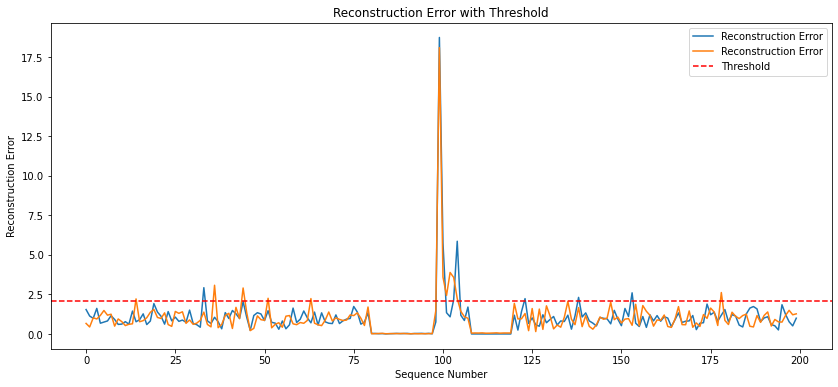

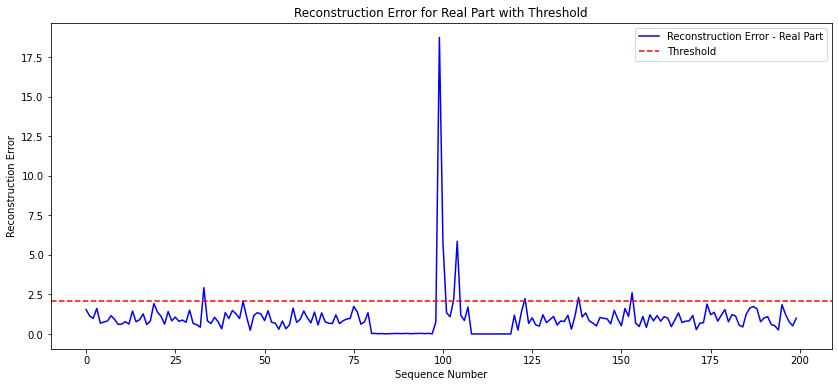

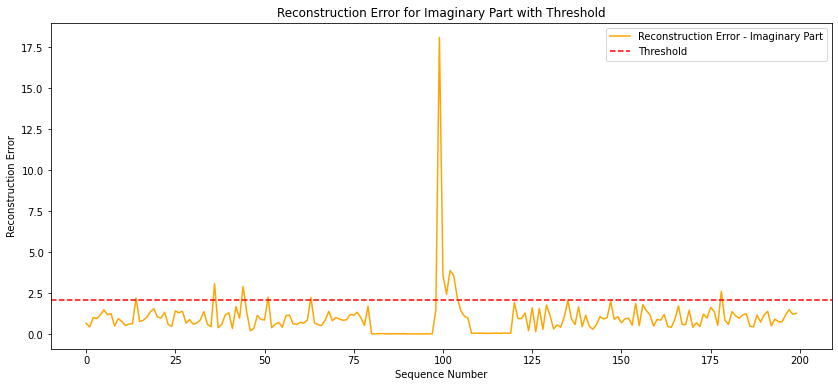

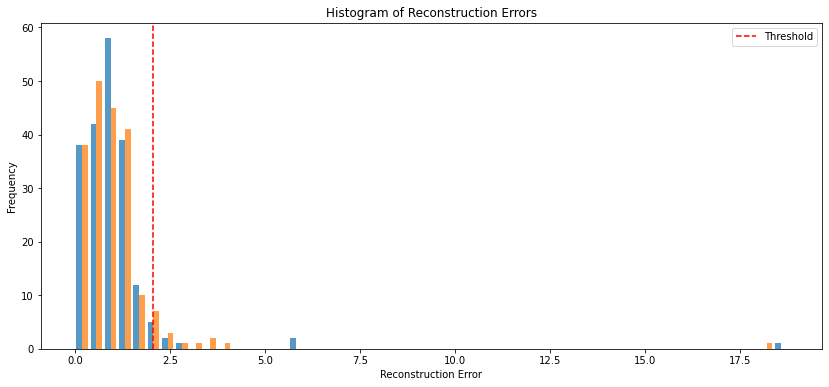

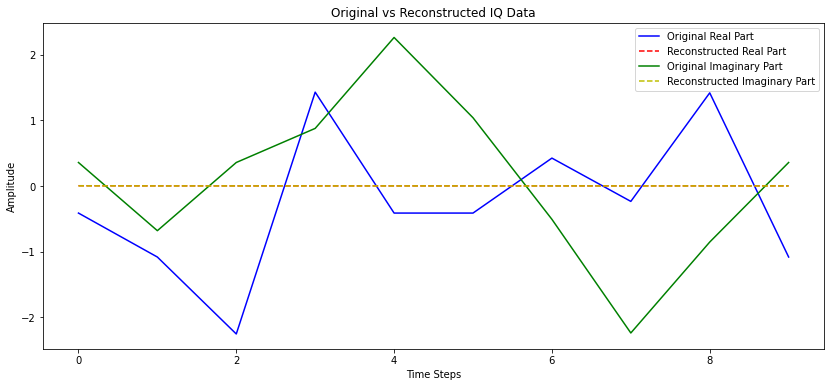

Shape of avg_real: (20,)
Shape of avg_imag: (20,)
Shape of last_errors: 20


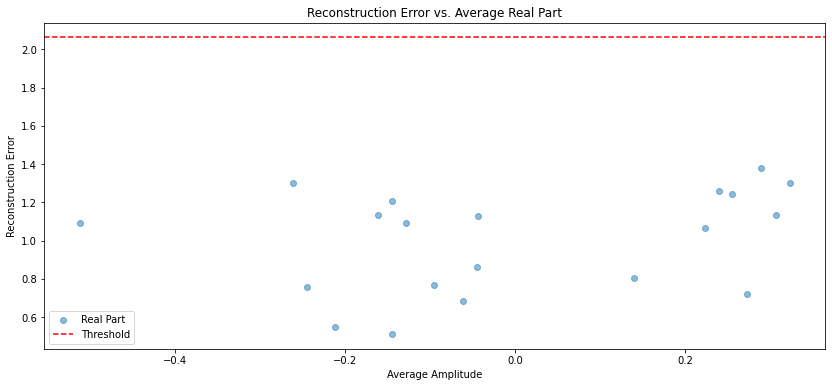

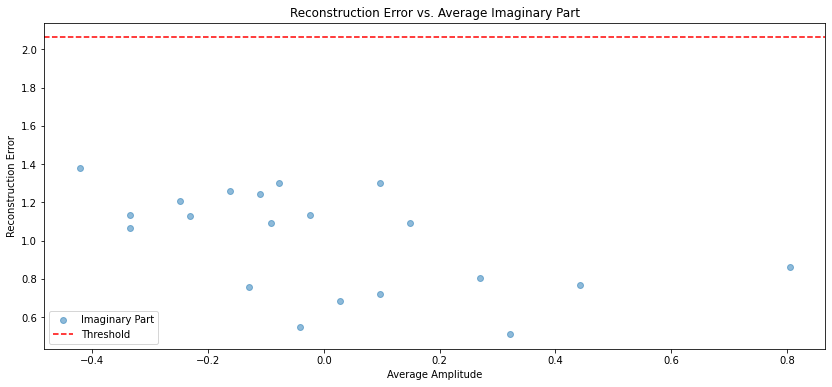

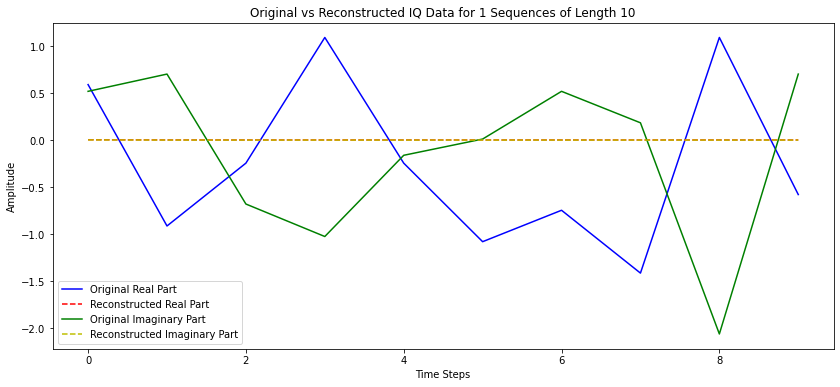

In [2]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_real, label='Reconstruction Error - Real Part', color='blue')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Real Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('2-Reconstruction Error for Real Part with Threshold.png')
# plt.close()
plt.show()

# Plot for Imaginary Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_imag, label='Reconstruction Error - Imaginary Part', color='orange')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Imaginary Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('3-Reconstruction Error for Imaginary Part with Threshold.png')
# plt.close()
plt.show()


#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()

#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

# # Define the number of sequences to plot together
n = 1  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


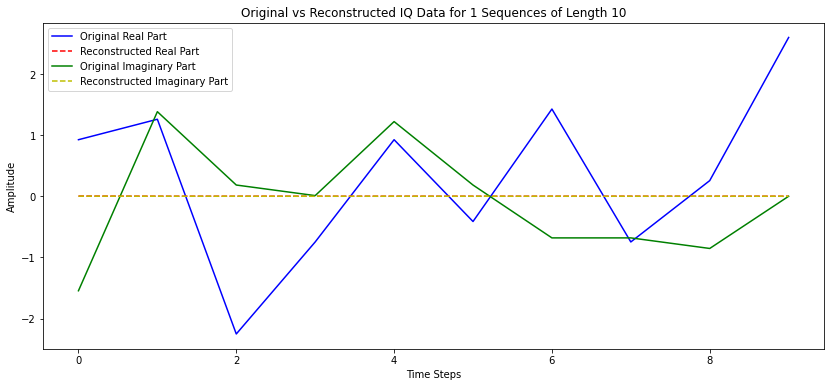

In [3]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

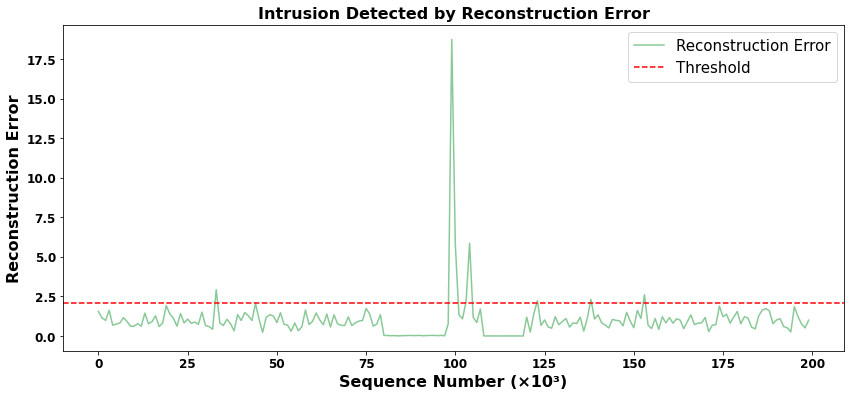

In [4]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

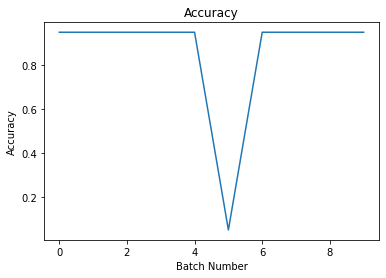

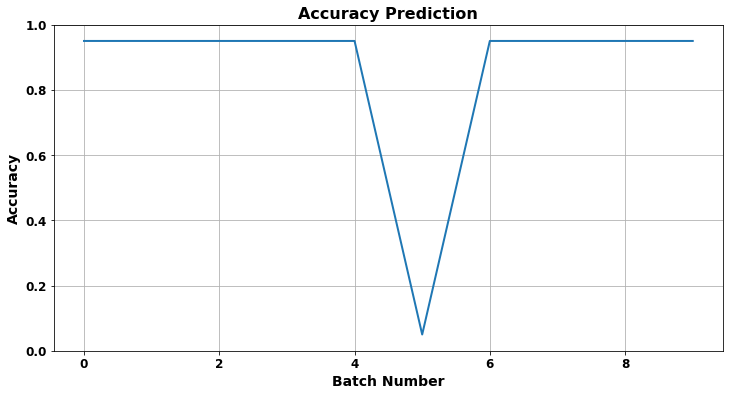

In [5]:
#accuracy
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accuracies, linewidth=2)
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
# set font size x-axis and y-axis values
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)  # Set y-axis limit to range to 0 to 1
plt.grid(True)
plt.show()

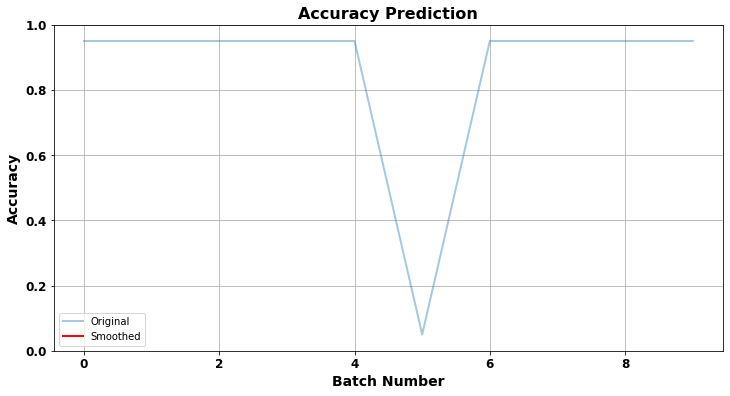

In [6]:
accuracies_series = pd.Series(accuracies)

# Smoothing-calculate the rolling mean (moving average) in window size
window_size = 10  # adjust to change the smoothing level
smoothed_accuracies = accuracies_series.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(accuracies, linewidth=2, alpha=0.4, label='Original')  #alpha for transparency
plt.plot(smoothed_accuracies, linewidth=2, color='red', label='Smoothed') # color to red
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()